In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
mpl.use('Agg')

import geopandas as gpd
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.io.img_tiles import Stamen
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

from matplotlib import gridspec
import time 
import scipy.stats as stats

from scipy.stats import kstest, cramervonmises
import tensorflow as tf
import tensorflow_probability as tfp
from pingouin import partial_corr

from ipcc_colormap import *
from utils import *

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

coastline = gpd.read_file('/home/mizu_home/xp53/nas/home/coastlines-split-SGregion/lines.shp')
mask = np.loadtxt('mask.txt')

ipcc_blue = (112.0/255, 160.0/255, 205.0/255, 1.0)
ipcc_orange = (196.0/255, 121.0/255, 0.0/255, 1.0)

tmp_cmap = ipcc_cmap()
tmp_cmap.read_rgb_data_from_excel()
;

2024-09-02 15:21:51.172440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 15:21:51.259953: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


''

In [2]:
# a hack from stackoverflow to normalize the colorbar and set arbitrary midpoint locations
# while maintaining the colorbar's linearity
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
# DATA PREPARATION
# the station-based rainfall data is already organized in a N by P matrix
rain_obs = np.loadtxt('data/sta_monthly.csv')

# the simulated rainfall data is reshaped to a 2d matrix of size N by (W x L)
rain_sim_flatten = np.loadtxt('data/wrf_monthly.csv')
rain_sim = rain_sim_flatten.reshape(rain_sim_flatten.shape[0], 120, 160)

# sim_sel constains a P by 4 matrix
# the first two columns are the row and column indices of grids corresponding to the stations
# the last two columns are the lons and lats of grids corresponding to the stations
sim_sel = np.loadtxt('data/wrf_loc.csv')
sim_idx = sim_sel[:, :2].astype(int)

# select simulated rainfall at stations
wrf_sta = np.array([rain_sim[:, i, j] for (i, j) in sim_idx]).T

# lats and lons of all grids are stored in a 2d matrix of 2 by (W x L)
# the first row is lons and the second row is lats
longlat = np.loadtxt('data/lonlat.txt')
lons = longlat[0, :].reshape(120, 160)
lats = longlat[1, :].reshape(120, 160)

# read station lons (3rd column) and lats (4th column)
sta_loc = np.genfromtxt('data/sta_lookup_new.csv', delimiter=',')[:, 2:]

# read wrf simulated rainfall forced by cmip6 future climate
cmip_rain_f = np.loadtxt('data/wrf_monthly_cmip.txt')[-40:, :]
cmip_rain0 = cmip_rain_f.reshape(cmip_rain_f.shape[0], 12, 120, 160)
cmip_rain = np.zeros(cmip_rain0.shape)
cmip_rain[:, 0:6, :, :] = cmip_rain0[:, 6:12, :, :]
cmip_rain[:, 6:12, :, :] = cmip_rain0[:, 0:6, :, :]
cmip_rain_flatten = np.reshape(cmip_rain, (40, 12, 120*160))
wrf_sta_fut = np.zeros((40, 12, sim_idx.shape[0]))
for idx, (i, j) in enumerate(sim_idx):
    wrf_sta_fut[:, :, idx] = cmip_rain[:, :, i, j]

In [ ]:
# leave-one-out cross validation to evaluate
# model accuracy using the Kling Gupta Efficiency (KGE) comparing posterior means with observations
# model accuracy & precision using the Kolmogorov-Smirnov (KS) statistic comparing inverted CDFs with a uniform distribution
# the CDFs are inverted using the prior distributions and the posterior distributions

tmp1 = gp_interpolator(P = sim_idx.shape[0] - 1)
kge0 = np.zeros((12, tmp1.p_ + 1))
kge1 = np.zeros((12, tmp1.p_ + 1))
ks_statistic0 = np.zeros((12, tmp1.p_ + 1, 2))
ks_statistic = np.zeros((12, tmp1.p_ + 1, 2))
# re-evaluate the obs given the posterior distribution
# this is for plotting the 'rank histograms' (but in the cdf form)
z_reeval0 = np.zeros((12, tmp1.p_ + 1, 40))
z_reeval = np.zeros((12, tmp1.p_ + 1, 40))

for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    for j in range(tmp1.p_ + 1):
        txx_obs = np.delete(xx_obs, j, axis = 1)
        txx_sim = np.delete(xx_sim, j, axis = 1)
        tmp1.read_rainfall(obs = txx_obs, sim = txx_sim)
        tmp1.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]
        yy_fit, yy_var = tmp1.predict(yy_sim)

        # compute the CDFs using the prior distributions estimated from raw simulations
        z_reeval0[i, j, :] = stats.norm.cdf(yy_obs.squeeze(),
                                   loc = np.mean(yy_sim),
                                   scale = np.std(yy_sim, ddof = 1))
        z_sorted0 = np.sort(z_reeval0[i, j, :])
        res0 = kstest(z_sorted0, 'uniform')
        ks_statistic0[i, j, 0], ks_statistic0[i, j, 1] = res0.statistic, res0.pvalue

        # compute the CDFs using the posterior distributions
        z_reeval[i, j, :] = stats.norm.cdf(yy_obs.squeeze(),
                                           loc = yy_fit.squeeze(),
                                           scale = np.sqrt(yy_var.squeeze()))
        z_sorted = np.sort(z_reeval[i, j, :])
        res = kstest(z_sorted, 'uniform')
        ks_statistic[i, j, 0], ks_statistic[i, j, 1] = res.statistic, res.pvalue
        
        yy_fit[yy_fit < 0] = 0 # set negative rainfall to 0

        kge0[i, j] = kge(yy_obs.squeeze(), yy_sim.squeeze())
        kge1[i, j] = kge(yy_obs.squeeze(), yy_fit.squeeze())

In [4]:
# leave-one-out cross validation to evaluate
# model accuracy using the Kling Gupta Efficiency (KGE) comparing posterior means with observations
# model accuracy & precision using the Kolmogorov-Smirnov (KS) statistic comparing inverted CDFs with a uniform distribution
# the CDFs are inverted using the prior distributions and the posterior distributions

# bias correction is first applied to the raw simulations
wrf_sta_bc = np.zeros(wrf_sta.shape)
for i in range(12):
    for j in range(14): 
        tmpxx = np.sort(wrf_sta[i::12, j])
        tmpyy = np.sort(rain_obs[i::12, j])
        lm = stats.linregress(tmpxx, tmpyy)
        wrf_sta_bc[i::12, j] = lm.slope * wrf_sta[i::12, j] + lm.intercept
        # wrf_sta_bc[i::12, j] = tmpxx + np.mean(tmpyy) - np.mean(tmpxx)

tmp1 = gp_interpolator(P = sim_idx.shape[0] - 1)
kge0 = np.zeros((12, tmp1.p_ + 1))
kge1 = np.zeros((12, tmp1.p_ + 1))
ks_statistic0 = np.zeros((12, tmp1.p_ + 1, 2))
ks_statistic = np.zeros((12, tmp1.p_ + 1, 2))
# re-evaluate the obs given the posterior distribution
# this is for plotting the 'rank histograms' (but in the cdf form)
z_reeval0 = np.zeros((12, tmp1.p_ + 1, 40))
z_reeval = np.zeros((12, tmp1.p_ + 1, 40))

for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta_bc[i::12, :]
    for j in range(tmp1.p_ + 1):
        txx_obs = np.delete(xx_obs, j, axis = 1)
        txx_sim = np.delete(xx_sim, j, axis = 1)
        tmp1.read_rainfall(obs = txx_obs, sim = txx_sim)
        tmp1.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]
        yy_fit, yy_var = tmp1.predict(yy_sim)

        # compute the CDFs using the prior distributions estimated from raw simulations
        z_reeval0[i, j, :] = stats.norm.cdf(yy_obs.squeeze(),
                                   loc = np.mean(yy_sim),
                                   scale = np.std(yy_sim, ddof = 1))
        z_sorted0 = np.sort(z_reeval0[i, j, :])
        res0 = kstest(z_sorted0, 'uniform')
        ks_statistic0[i, j, 0], ks_statistic0[i, j, 1] = res0.statistic, res0.pvalue

        # compute the CDFs using the posterior distributions
        z_reeval[i, j, :] = stats.norm.cdf(yy_obs.squeeze(),
                                           loc = yy_fit.squeeze(),
                                           scale = np.sqrt(yy_var.squeeze()))
        z_sorted = np.sort(z_reeval[i, j, :])
        res = kstest(z_sorted, 'uniform')
        ks_statistic[i, j, 0], ks_statistic[i, j, 1] = res.statistic, res.pvalue
        
        yy_fit[yy_fit < 0] = 0 # set negative rainfall to 0

        kge0[i, j] = kge(yy_obs.squeeze(), yy_sim.squeeze())
        kge1[i, j] = kge(yy_obs.squeeze(), yy_fit.squeeze())
np.savetxt('kge0_bc.csv', kge0)
np.savetxt('kge1_bc.csv', kge1)

In [ ]:
ks_kriging = np.loadtxt('kriging_ks.csv')
# the KS statistic box plot
fig, ax = plt.subplots(1, 1, figsize = (6, 3))
# plot the kge0 boxplot at positions of x with filler color of red
bp1 = ax.boxplot(ks_statistic0[:,:,0].T, positions = np.arange(12) - 0.1, widths = 0.1,
           patch_artist = True, boxprops=dict(facecolor=ipcc_orange), medianprops=dict(color="black"))
bp2 = ax.boxplot(ks_statistic[:,:,0].T, positions = np.arange(12) + 0.1, widths = 0.1,
           patch_artist = True, boxprops=dict(facecolor=ipcc_blue), medianprops=dict(color="black"))
bp3 = ax.scatter(np.arange(12) + 0.1, np.median(ks_kriging.T, axis = 0), s = 15, marker = '^', color = 'green', zorder = 10)
# ax.axline((0, 0.25), (11, 0.25), color = 'black', linestyle = '--')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('K-S Statistic')
ax.set_yticks([0, 0.5, 1])
# ax.set_yscale('log')
# set minor ticks on y axis with an interval of 0.25
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))
ax.grid(which = 'both', axis = 'y', linestyle = '--')
handles = [bp1["boxes"][0], bp2["boxes"][0], bp3]
labels = ['Raw', 'Posterior', 'Kriging']
ax.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize=10, frameon=False)

fig.savefig('figures_new/KS_statistic_boxplot_poster_bias_correct.pdf')
;

In [ ]:
# the scatter plots of CDFs vs ECDFs (uniform distribution)
path = 'figures_new/scatter_plots/'
str = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
ecdf = (np.arange(1, 41) - 0.5) / 41
for i in range(12):
    fig, ax = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
    for j in range(14):  # Plot only for 14 stations
        ri, ci = divmod(j, 4)  # Calculate row, column index
        tmp_z = z_reeval[i, j, :]
        tmp_z0 = z_reeval0[i, j, :]
        ax[ri, ci].scatter(ecdf, np.sort(tmp_z0), marker = 'D', s = 20, color = ipcc_orange, label = 'raw')
        ax[ri, ci].scatter(ecdf, np.sort(tmp_z), marker = 'o', s = 20, color = ipcc_blue, label = 'posterior')
        ax[ri, ci].axline([0, 0], [1, 1], color='black', linestyle='--')
        ax[ri, ci].set_title('(' + str[j] + ')')
        ax[ri, ci].set_xlim([0, 1])  # Set x-axis to start from 0
        ax[ri, ci].set_ylim([0, 1])  # Set y-axis to start from 0
    
    # Hide unused subplots
    for k in range(14, 16):
        ax[k // 4, k % 4].axis('off')

    ax[2, 2].tick_params(axis='x', which='both', labelbottom=True)  # Figure (k)
    ax[2, 3].tick_params(axis='x', which='both', labelbottom=True)  # Figure (l)

    # Place a single legend on the last row's leftmost subplot
    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.6, 0.1), fontsize = 14)

    # Add shared x and y axis labels
    fig.text(0.5, 0.01, 'empirical cumulative distribution', ha='center', va='center', fontsize='large')
    fig.text(0.01, 0.5, 'estimated cumulative distribution', ha='center', va='center', rotation='vertical', fontsize='large')

    plt.subplots_adjust(left=0.12, right=0.9, top=0.9, bottom=0.12)  # Adjust the subplots to provide space for labels
    plt.tight_layout(pad=2)  # Increase padding to avoid overlap
    # plt.show()

    # fig.savefig(f'{path}pp_plot_{i+1}.pdf')
    plt.close(fig)

''

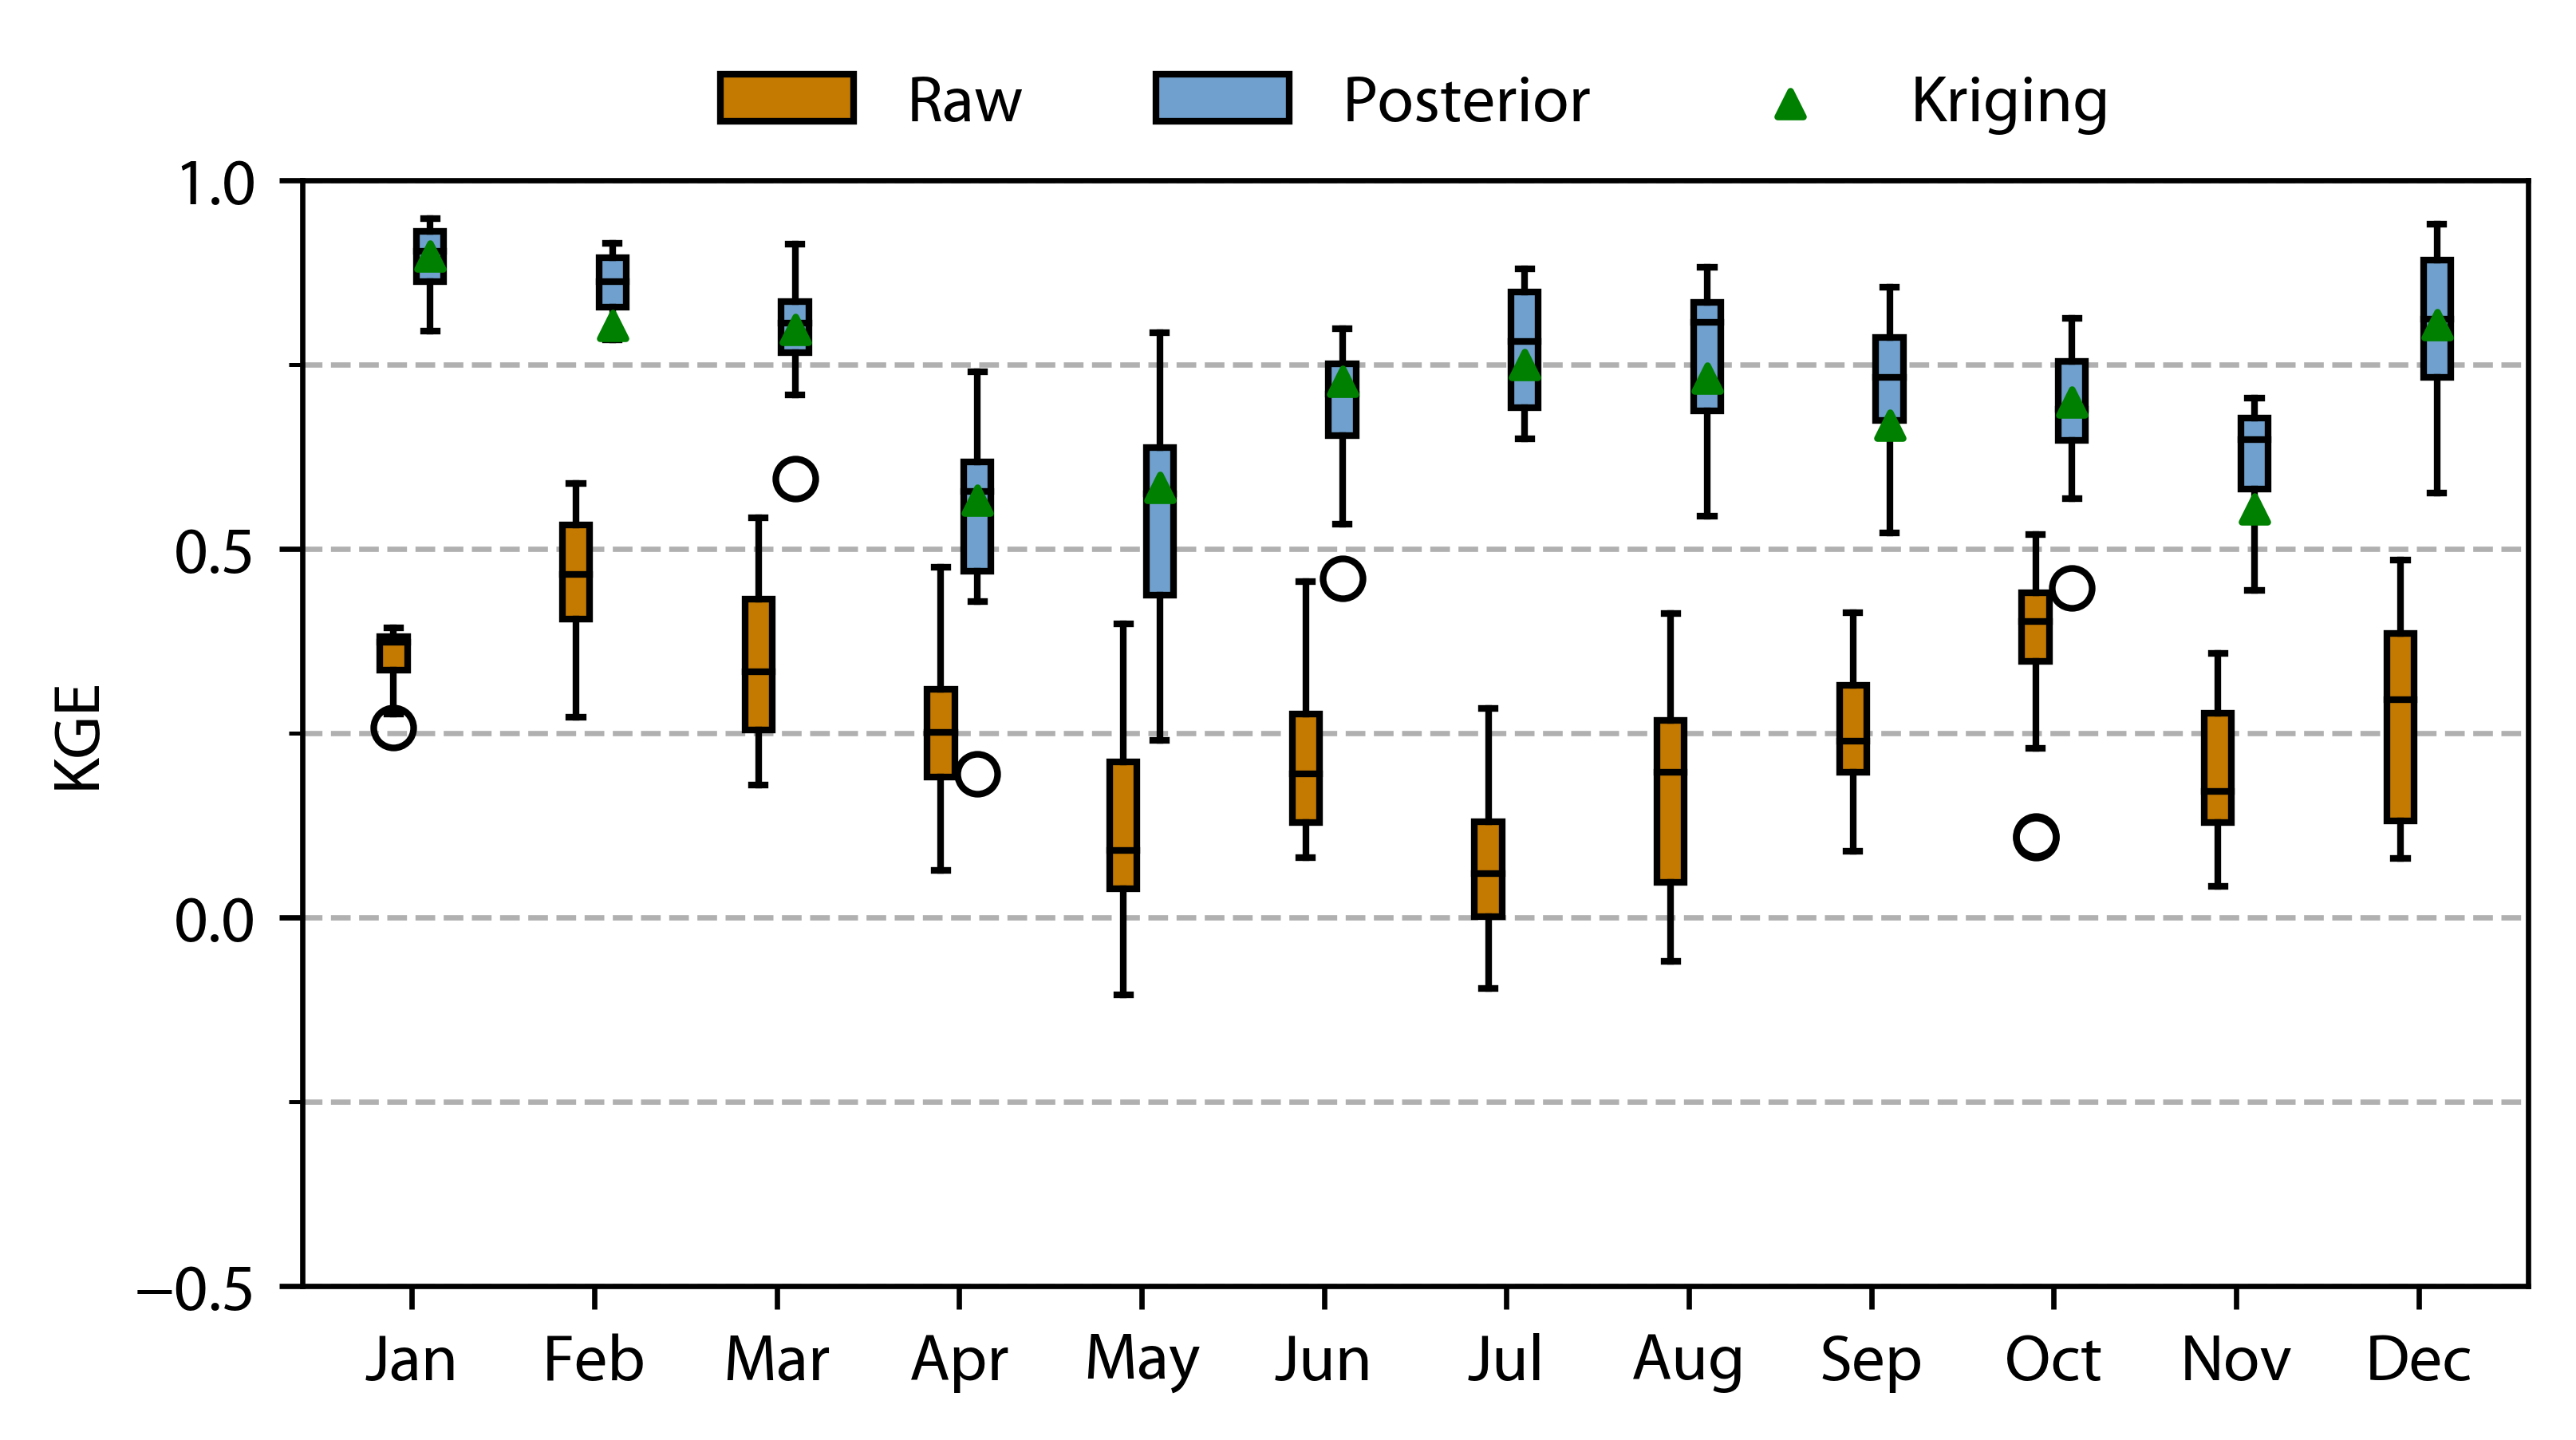

In [6]:
kge_kriging = np.loadtxt('kriging_kge.csv')
# the KGE boxplot
fig, ax = plt.subplots(1, 1, figsize = (6, 3))
# plot the kge0 boxplot at positions of x with filler color of red
bp1 = ax.boxplot(kge0.T, positions = np.arange(12) - 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_orange), medianprops=dict(color="black"))
bp2 = ax.boxplot(kge1.T, positions = np.arange(12) + 0.1, widths = 0.15,
           patch_artist = True, boxprops=dict(facecolor=ipcc_blue), medianprops=dict(color="black"))
bp3 = ax.scatter(np.arange(12) + 0.1, np.median(kge_kriging.T, axis = 0), s = 15, marker = '^', color = 'green', zorder = 10)

# ax.axline((0, 0), (11, 0), color = 'black', linestyle = '--')
ax.set_xticks(np.arange(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('KGE')
ax.set_ylim([-0.5, 1])
ax.set_yticks([-0.5, 0, 0.5, 1])
# set minor ticks on y axis with an interval of 0.25
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))
ax.grid(which = 'both', axis = 'y', linestyle = '--')
# Place the legend horizontally above the plot
handles = [bp1["boxes"][0], bp2["boxes"][0], bp3]
labels = ['Raw', 'Posterior', 'Kriging']
ax.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.15), fontsize=10, frameon=False)

fig.savefig('figures_new/KGE_boxplot_poster_bias_correct.pdf')
;

In [7]:
low_bm = np.quantile(kge1, [0.25], axis = 1)
low_kriging = np.quantile(kge_kriging, [0.25], axis = 1)
print(low_bm > low_kriging)

[[ True  True  True  True  True  True  True  True  True  True  True  True]]


In [25]:
np.sum((kge1 >= kge_kriging), axis = 1) / 14

array([0.5       , 0.85714286, 0.5       , 0.57142857, 0.57142857,
       0.64285714, 0.64285714, 0.5       , 0.57142857, 0.57142857,
       0.64285714, 0.64285714])

In [24]:
tmp = np.random.randint(2, size=(100000, 14))
success_rate = np.sum(tmp, axis = 1) / 14
np.sum(success_rate >= 9/14) / 100000

0.21156

In [ ]:
post_kge_bc = np.median(np.loadtxt('kge1_bc.csv'), axis = 1)
post_kge = np.median(kge1, axis = 1)
kriging_kge = np.median(kge_kriging, axis = 1)
prior_ks = np.median(ks_statistic0[:,:,0], axis = 1)
post_ks = np.median(ks_statistic[:,:,0], axis = 1)
print(np.corrcoef(prior_ks, kriging_kge - post_kge))
print(np.corrcoef(post_ks, kriging_kge - post_kge))
fig, ax = plt.subplots(1, 2, figsize = (9, 4))
ax[0].scatter(prior_ks, kriging_kge - post_kge, s = 20, color = ipcc_orange, label = r'prior KS, $\rho$ = 0.72')
lm = stats.linregress(prior_ks, kriging_kge - post_kge)
xx = np.array([np.min(prior_ks), np.max(prior_ks)])
ax[0].plot(xx, lm.slope * xx + lm.intercept, color = ipcc_orange)
ax[0].scatter(post_ks, kriging_kge - post_kge, s = 20, color = ipcc_blue, label = r'posterior KS, $\rho$ = 0.79')
lm = stats.linregress(post_ks, kriging_kge - post_kge)
xx = np.array([np.min(post_ks), np.max(post_ks)])
ax[0].plot(xx, lm.slope * xx + lm.intercept, color = ipcc_blue)
ax[0].legend()
ax[0].set_xlabel('K-S statistic')
ax[0].set_ylabel('KGE diff')

print(np.corrcoef(prior_ks, post_kge_bc - post_kge))
print(np.corrcoef(post_ks, post_kge_bc - post_kge))
ax[1].scatter(prior_ks, post_kge_bc - post_kge, s = 20, color = ipcc_orange, label = r'prior KS, $\rho$ = 0.68')
lm = stats.linregress(prior_ks, post_kge_bc - post_kge)
xx = np.array([np.min(prior_ks), np.max(prior_ks)])
ax[1].plot(xx, lm.slope * xx + lm.intercept, color = ipcc_orange)
ax[1].scatter(post_ks, post_kge_bc - post_kge, s = 20, color = ipcc_blue, label = r'posterior KS, $\rho$ = 0.85')
lm = stats.linregress(post_ks, post_kge_bc - post_kge)
xx = np.array([np.min(post_ks), np.max(post_ks)])
ax[1].plot(xx, lm.slope * xx + lm.intercept, color = ipcc_blue)
ax[1].legend()
ax[1].set_xlabel('K-S statistic')
ax[1].set_ylabel('KGE diff')

In [ ]:
# unfolding the KS statistic boxplot into two heatmaps (as function of station and month)

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
mpl.rcParams.update({'font.size': 12})
# Define the colormap and normalization
cmap = 'coolwarm'
norm = MidpointNormalize(vmin=0, vmax=1, midpoint=0.252)

# Plotting KGE0
img0 = ax[0].imshow(ks_statistic0[:,:,0].squeeze(), cmap=cmap, norm=norm)  # Transpose array for correct orientation
ax[0].set_xticks(np.arange(14))
ax[0].set_xticklabels(np.arange(1, 15))
ax[0].set_yticks(np.arange(12))
ax[0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0].set_ylabel('Month', fontsize = 14)
ax[0].set_title('(a) raw')

# Plotting KGE1
img1 = ax[1].imshow(ks_statistic[:,:,0].squeeze(), cmap=cmap, norm=norm)  # Transpose array for correct orientation
ax[1].set_xticks(np.arange(14))
ax[1].set_xticklabels(np.arange(1, 15))
ax[1].set_title('(b) posterior')

# Set a common x-label
fig.text(0.46, 0.06, 'Station', ha='center', va='center', fontsize = 14)

# Adjust layout to leave space for colorbar
fig.subplots_adjust(right=0.8, bottom=0.05)

# Create a colorbar with the correct positioning
cbar_ax = fig.add_axes([0.82, 0.15, 0.012, 0.63])  # Adjust the colorbar to match subplot height
cbar = fig.colorbar(img1, cax=cbar_ax)
cbar.set_label('K-S statistic')

# Set major and minor ticks on the colorbar
cbar.set_ticks([0, 0.25, 1])
cbar.ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

plt.show()
fig.savefig('figures_new/KS_statistic_heatmap.pdf')
;

In [ ]:
# unfolding the KGE boxplot into two heatmaps (as function of station and month)

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
mpl.rcParams.update({'font.size': 12})
# Define the colormap and normalization
cmap = 'coolwarm_r'
norm = MidpointNormalize(vmin=-0.5, vmax=1, midpoint=0)

# Plotting KGE0
img0 = ax[0].imshow(kge0, cmap=cmap, norm=norm)  # Transpose array for correct orientation
ax[0].set_xticks(np.arange(14))
ax[0].set_xticklabels(np.arange(1, 15))
ax[0].set_yticks(np.arange(12))
ax[0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax[0].set_ylabel('Month', fontsize = 14)
ax[0].set_title('(a) raw')

# Plotting KGE1
img1 = ax[1].imshow(kge1, cmap=cmap, norm=norm)  # Transpose array for correct orientation
ax[1].set_xticks(np.arange(14))
ax[1].set_xticklabels(np.arange(1, 15))
ax[1].set_title('(b) posterior')

# Set a common x-label
fig.text(0.46, 0.06, 'Station', ha='center', va='center', fontsize = 14)

# Adjust layout to leave space for colorbar
fig.subplots_adjust(right=0.8, bottom=0.05)

# Create a colorbar with the correct positioning
cbar_ax = fig.add_axes([0.82, 0.15, 0.012, 0.63])  # Adjust the colorbar to match subplot height
cbar = fig.colorbar(img1, cax=cbar_ax)
cbar.set_label('KGE')

# Set major and minor ticks on the colorbar
cbar.set_ticks([-0.5, 0, 0.5, 1])
cbar.ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.25))

plt.show()
fig.savefig('figures_new/KGE_heatmap.pdf')
;

In [ ]:
# the scatter plots of raw vs posterior mean

path = 'figures_new/scatter_plots/'
str = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
for i in range(12):
    xx_obs = rain_obs[i::12, :]
    xx_sim = wrf_sta[i::12, :]
    fig, ax = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)
    for j in range(14):  # Plot only for 14 stations
        ri, ci = divmod(j, 4)  # Calculate row, column index
        txx_obs = np.delete(xx_obs, j, axis=1)
        txx_sim = np.delete(xx_sim, j, axis=1)
        tmp1.read_rainfall(obs=txx_obs, sim=txx_sim)
        tmp1.sn_converge()
        yy_sim = xx_sim[:, j][:, None]
        yy_obs = xx_obs[:, j][:, None]
        yy_fit, _ = tmp1.predict(yy_sim)
        yy_fit[yy_fit < 0] = 0
        ax[ri, ci].scatter(yy_obs, yy_sim, color=ipcc_orange, marker='D', s=20, label='raw')
        ax[ri, ci].scatter(yy_obs, yy_fit, color=ipcc_blue, marker='o', s=20, label='posterior')
        ax[ri, ci].axline([0, 0], [1, 1], color='black', linestyle='--')
        tmp_kge1 = kge(yy_obs.squeeze(), yy_fit.squeeze())
        tmp_kge0 = kge(yy_obs.squeeze(), yy_sim.squeeze())
        ax[ri, ci].set_title('(' + str[j] + f') KGE = {tmp_kge1:.2f} ({tmp_kge0:.2f})')
        ax[ri, ci].set_xlim(left=0)  # Set x-axis to start from 0
        ax[ri, ci].set_ylim(bottom=0)  # Set y-axis to start from 0
    
    # Hide unused subplots
    for k in range(14, 16):
        ax[k // 4, k % 4].axis('off')

    ax[2, 2].tick_params(axis='x', which='both', labelbottom=True)  # Figure (k)
    ax[2, 3].tick_params(axis='x', which='both', labelbottom=True)  # Figure (l)

    # Place a single legend on the last row's leftmost subplot
    handles, labels = ax[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.6, 0.1), fontsize = 14)

    # Add shared x and y axis labels
    fig.text(0.5, 0.01, 'Observed Rainfall [mm]', ha='center', va='center', fontsize='large')
    fig.text(0.01, 0.5, 'Estimated Rainfall [mm]', ha='center', va='center', rotation='vertical', fontsize='large')

    plt.subplots_adjust(left=0.12, right=0.9, top=0.9, bottom=0.12)  # Adjust the subplots to provide space for labels
    plt.tight_layout(pad=2)  # Increase padding to avoid overlap
    # plt.show()

    # fig.savefig(f'{path}scatter_{i+1}.pdf')
    plt.close(fig)
;

in our context, the sn var measures the mismatch between the rainfall at the pixel and the corresponding observational rainfall.

To better understand its effect on the performance of the rainfall interpolation: suppose we can fix everything and only manuver the sn value at a specific pixel-station, lets consider two cases:

1. the data (and sn value) is known for this pixel-station, we are making inference of rainfall at other pixels using this info: a larger sn value will reduce the control of obs from this station on other pixels -> adding info from a station like this will not be very helpful

2. the sn value is not known, we are making inference of rainll about this specific station, the discrepency insreases with increasing sn value and less 'local' control of the station-based data on the rainfall at this pixel.

so basically sn acts as a valve controling info flow into and from the specific station in the rainfall interpolation 

Through this point of view, we may speculate that the model at a pixel-station associated with a high sn value may may show more variability (and less robustness). 

In [ ]:
# starting from this part, i do not have to do CV for model evaluation
# all stations are used for calibrating the local noises

tmp = gp_interpolator(P = sim_idx.shape[0])
sn = np.zeros((14, ))
for i in range(12):
    tmp.read_rainfall(rain_obs[i::12, :], wrf_sta[i::12, :])
    tmp.sn_converge()
    sn = sn + 1 / 12 * tmp.sn


In [ ]:
import cartopy.io.img_tiles as cimgt

# a hack to use the old stamen base maps from the new stadia server
class StadiaStamen(cimgt.Stamen):
    def _image_url(self, tile):
         x,y,z = tile
         url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}.png?api_key=9de40773-c642-4a20-bcec-d168a244e11e"
         return url
    
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[6, 8], subplot_kw={'projection': crs.PlateCarree()})

max_radius = 0.02  # Max circle radius in degrees

ax.set_extent([103.58, 104.12, 1.153, 1.502], crs=crs.PlateCarree())

tiler = StadiaStamen("terrain")
mercator = tiler.crs
ax.add_image(tiler, 14) 

coastline.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
gl = ax.gridlines(crs=crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([103.5, 103.6, 103.7, 103.8, 103.9, 104.0, 104.1])
gl.ylocator = mticker.FixedLocator([1.1, 1.2, 1.3, 1.4, 1.5])

sn_thre = np.median(sn)
# plot the station locations as circles per the location info stored in a 2d array sta_loc of size P by 2
# the radius of the circles is proportional to the value of sn
for loc, tsn in zip(sta_loc, sn):
    radius = (tsn / max(sn)) * max_radius  # Scale radius
    if tsn < sn_thre:
        circle = Circle(xy=(loc[0], loc[1]), radius=radius, color='blue', alpha=0.25, transform=crs.PlateCarree())
    else:
        circle = Circle(xy=(loc[0], loc[1]), radius=radius, color='red', alpha=0.25, transform=crs.PlateCarree())
    ax.add_patch(circle)

fig.savefig('figures_new/noise_distribution_map.pdf')

tmp_sn_ = [np.max(sn), np.min(sn), np.median(sn)]
print(tmp_sn_)
print([100 * i / tmp_sn_[0] * max_radius for i in tmp_sn_])


Can these sn values be associated with urbanization -> surface roughness. higher urbanization -> higher surface roughness -> more heteorogenity -> larger uncertainty -> bigger sn values -> worse performance of the inerpolation model -> call for other monitoring tools for urbanized areas. 

In [ ]:
# interpolate to all grids
gpr_ = gp_interpolator(P = sim_idx.shape[0])

sg_plotter = sg_map_plotter(lons, lats, coastline)
cmap = tmp_cmap.get_ipcc_cmap('seq', 'prec', 20)

fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(4, 3, height_ratios=[1,1,1,1], bottom=0.1, top=0.95, left=0.05, right=0.95,
                       wspace=0.05, hspace=0.05)  # Leave space at the bottom for the colorbar

axes = [plt.subplot(gs[i, j], projection=crs.PlateCarree()) for i in range(4) for j in range(3)]

for i, ax in enumerate(axes):
    t1 = time.time()
    gpr_.read_rainfall(rain_obs[i::12, :], wrf_sta[i::12, :])
    gpr_.sn_converge()
    tmp_mu, _ = gpr_.predict(rain_sim_flatten[i::12, :])
    tmp_mu = tmp_mu.T
    tmp_mu = np.reshape(np.mean(tmp_mu, axis = 0), (120, 160))
    # tmp_mu = np.zeros((120, 160))
    sg_plotter.plot_(ax, tmp_mu, cmap = cmap, vmin = 0, vmax = 400)
    sg_plotter.plot_scatter(ax, sta_loc, size = 15)
    print(f'{i+1}th month: {time.time() - t1:.2f} sec, the min and max are {np.min(tmp_mu):.2f} and {np.max(tmp_mu):.2f}')

# Adjust the colorbar placement
cbar_ax = fig.add_axes([0.06, 0.07, 0.88, 0.015])  # Position: [left, bottom, width, height]
bounds = np.linspace(0, 400, 21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=12)
# make label font larger and bold
cb.set_label('Rainfall Climatology [mm]', fontsize=12, fontweight='bold')

fig.savefig('figures_new/poster_mean.pdf')


In [ ]:
# interpolate to all grids
gpr_ = gp_interpolator(P = sim_idx.shape[0])

sg_plotter = sg_map_plotter(lons, lats, coastline)
cmap = tmp_cmap.get_ipcc_cmap('seq', 'temp', 20)

fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(4, 3, height_ratios=[1,1,1,1], bottom=0.1, top=0.95, left=0.05, right=0.95,
                       wspace=0.05, hspace=0.05)  # Leave space at the bottom for the colorbar

axes = [plt.subplot(gs[i, j], projection=crs.PlateCarree()) for i in range(4) for j in range(3)]

for i, ax in enumerate(axes):
    t1 = time.time()
    gpr_.read_rainfall(rain_obs[i::12, :], wrf_sta[i::12, :])
    gpr_.sn_converge()
    _, tmp_var = gpr_.predict(rain_sim_flatten[i::12, :])
    tmp_var = np.reshape(np.diag(tmp_var), (120, 160))
    sg_plotter.plot_(ax, np.sqrt(tmp_var), cmap = cmap, vmin = 0, vmax = 300)
    sg_plotter.plot_scatter(ax, sta_loc, size = 15)
    print(f'{i+1}th month: {time.time() - t1:.2f} sec, the min and max are {np.sqrt(np.min(tmp_var)):.2f} and {np.sqrt(np.max(tmp_var)):.2f}')

# Adjust the colorbar placement
cbar_ax = fig.add_axes([0.06, 0.07, 0.88, 0.015])  # Position: [left, bottom, width, height]
bounds = np.linspace(0, 300, 21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=12)
# make label font larger and bold
cb.set_label('Rainfall Sigma [mm]', fontsize=12, fontweight='bold')

fig.savefig('figures_new/poster_var.pdf')


In [ ]:
path = 'cmip_era5_comparison/'
obs = np.loadtxt(path + 'obs.txt')
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (9.5, 12))
for i in range(12):
    era_intp = np.loadtxt(path + f'era5/sample_{i}.txt')
    cmip_intp = np.loadtxt(path + f'cmip6/sample_{i}.txt') 
    ridx, cidx = divmod(i, 3)
    uq_era = np.percentile(era_intp, [95], axis = 1) - np.percentile(era_intp, [5], axis = 1)
    uq_cmip = np.percentile(cmip_intp, [95], axis = 1) - np.percentile(cmip_intp, [5], axis = 1)
    
    ax[ridx][cidx].scatter(obs[i, :], np.mean(era_intp, axis = 1), s = 40, color = ipcc_blue, label = 'ERA5', alpha = 0.67, edgecolors = 'None')
    ax[ridx][cidx].scatter(obs[i, :], np.mean(cmip_intp, axis = 1), s = 40, color = ipcc_orange, label = 'CMIP6', alpha = 0.67, edgecolors = 'None')
    ax[ridx][cidx].axline([0, 0], [1, 1], color = 'black', linestyle = '--')
    x_min, x_max = np.min(obs[i, :]), np.max(obs[i, :])
    y_min_era, y_max_era = np.min(np.mean(era_intp, axis = 1)), np.max(np.mean(era_intp, axis = 1))
    y_min_cmip, y_max_cmip = np.min(np.mean(cmip_intp, axis = 1)), np.max(np.mean(cmip_intp, axis = 1))
    tmp_min = min(x_min, y_min_era, y_min_cmip)
    tmp_max = max(x_max, y_max_era, y_max_cmip)

    ax[ridx][cidx].set_xlim([np.max([0, tmp_min - 20]), tmp_max + 20])
    ax[ridx][cidx].set_ylim([np.max([0, tmp_min - 20]), tmp_max + 20])
    # set tick gap to 100
    ax[ridx][cidx].xaxis.set_major_locator(mticker.MultipleLocator(100))
    ax[ridx][cidx].yaxis.set_major_locator(mticker.MultipleLocator(100))
    # use a square plot
    ax[ridx][cidx].set_aspect('equal', adjustable='box')
    if i == 11:
        ax[ridx][cidx].legend(loc = 'lower right')

    era_mu = np.mean(era_intp, axis = 1)
    cmip_mu = np.mean(cmip_intp, axis = 1)

    rsq_era = 1 - np.sum((obs[i, :] - era_mu) ** 2) / np.sum((era_mu - np.mean(era_mu)) ** 2)
    rsq_cmip = 1 - np.sum((obs[i, :] - cmip_mu) ** 2) / np.sum((cmip_mu - np.mean(cmip_mu)) ** 2)
    print(f'{i+1}th month: R^2 for ERA5 and CMIP6 are {rsq_era:.2f} and {rsq_cmip:.2f}')

fig.tight_layout()
fig.savefig('figures_new/cmip_era5_comparison.pdf')